In [175]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import models, layers, optimizers, backend, callbacks
from sklearn import ensemble
from sklearn import linear_model

import zillow

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

# Load and Inspect Data

In [3]:
df = zillow.LoadTabularData("data/")

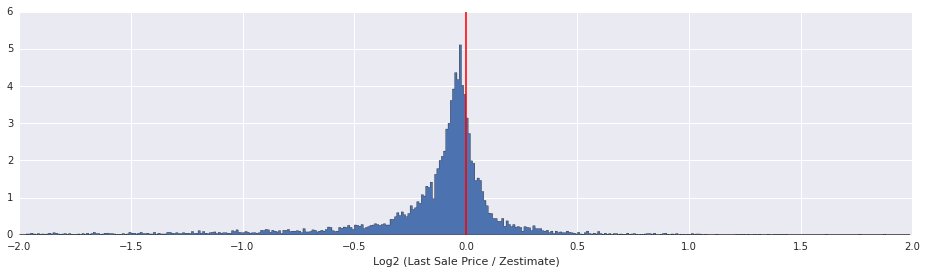

In [6]:
figsize(16, 4)
plt.hist(df.log_sold_to_zestimate, bins=np.arange(-2, 2, 0.01), histtype="stepfilled", normed=True)
plt.vlines(0, 0, 6, edgecolor="red", alpha=0.9)
plt.xlabel("Log2 (Last Sale Price / Zestimate)")
plt.show()

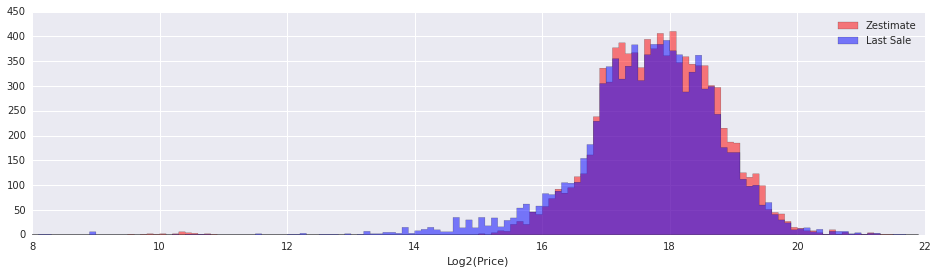

In [7]:
figsize(16, 4)
plt.hist(
    np.log2(df.zestimate), bins=np.arange(8, 22, 0.1),
    color="red", alpha=0.5, histtype="stepfilled", label="Zestimate")
plt.hist(
    np.log2(df.last_sold), bins=np.arange(8, 22, 0.1),
    color="blue", alpha=0.5, histtype="stepfilled", label="Last Sale")
plt.xlabel("Log2(Price)")
plt.legend()
plt.show()

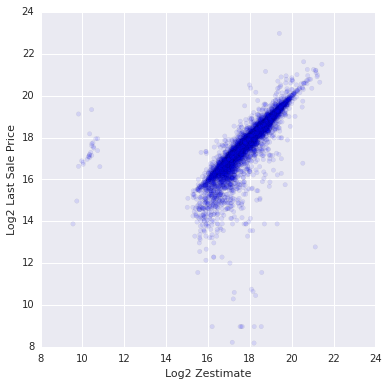

In [8]:
figsize(6, 6)
plt.scatter(np.log2(df.zestimate), np.log2(df.last_sold), alpha=0.1)
plt.xlabel("Log2 Zestimate")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.show()

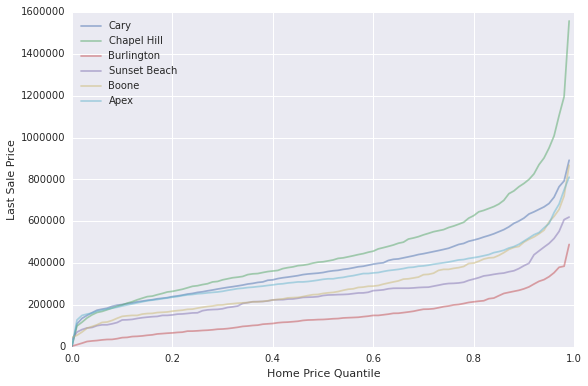

In [9]:
QUANTILES = np.arange(0, 1, 0.01)

def GetSaleQuantilesForCity(city):
    return df[df.city == city].last_sold.quantile(QUANTILES)

figsize(9, 6)
for city in ("Cary", "Chapel Hill", "Burlington", "Sunset Beach", "Boone", "Apex"):
    plt.plot(
        QUANTILES, GetSaleQuantilesForCity(city),
        label=city, alpha=0.5)
plt.legend(loc="upper left")
plt.xlabel("Home Price Quantile")
plt.ylabel("Last Sale Price")
plt.show()

# Prepare Data for Training

In [10]:
df["region"] = df.city + df.state + df.zip.astype(str)
region_encoder = dict((r, n) for n, r in enumerate(df.region.unique()))
df["region_code"] = df.region.map(lambda r: region_encoder[r])

In [11]:
ixs = np.arange(df.shape[0])
np.random.shuffle(ixs)
n_test = int(df.shape[0] / 10)
test_ixs = ixs[:n_test]
train_ixs = ixs[n_test:]
test_df = df.iloc[test_ixs]
train_df = df.iloc[train_ixs]

# Traditional ML & Statistical Models Trained on Home Facts

### Vectorize Regions and Home Facts
We create a vector of sparse binary features, each corresponding to either a region (city + state + zip) or a common property of homes.

In [12]:
reload(zillow)
vectorizer, vf = zillow.VectorizeFacts(df.region.map(lambda r: [r]) + df.facts)
vf.shape

(9288, 436)

### Random Forest Regression

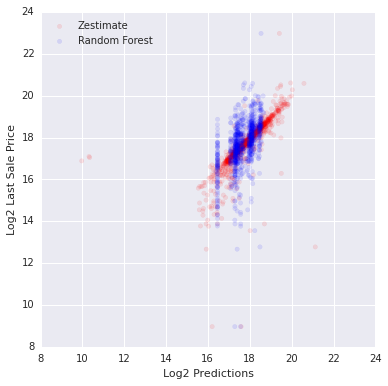

In [13]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, max_leaf_nodes=10, n_jobs=-1)
rfr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

rfr_preds = rfr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    rfr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Random Forest", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Ordinary Least Squares Regression

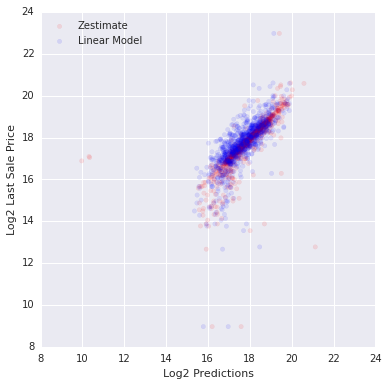

In [15]:
olsr = linear_model.LinearRegression(n_jobs=-1)
olsr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

olsr_preds = olsr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    olsr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Linear Model", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Ridge Regression

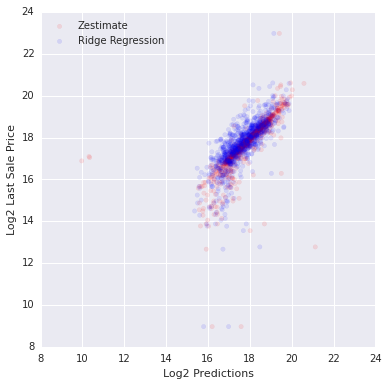

In [16]:
rr = linear_model.Ridge()
rr.fit(vf[train_ixs], np.log2(train_df.last_sold))

rr_preds = rr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    rr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Ridge Regression", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

# Deep Learning Models

### Multi-Layer Dense Network

In [18]:
def FactRegressor(n_facts, hidden_sizes=[100, 50, 20], nonlin=layers.advanced_activations.ELU):
    model = models.Sequential()
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            model.add(layers.Dropout(0.5))
        model.add(layers.Dense(out_size, input_dim=in_size))
        model.add(nonlin())
    return model

In [19]:
fr = FactRegressor(vf.shape[1], hidden_sizes=[258, 128, 64, 32, 16])

In [20]:
fr.compile(optimizer="adam", loss="mse")

In [21]:
fr_history = fr.fit(
    vf[train_ixs],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=500,
    verbose=0,
    validation_data=(
        vf[test_ixs],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True)

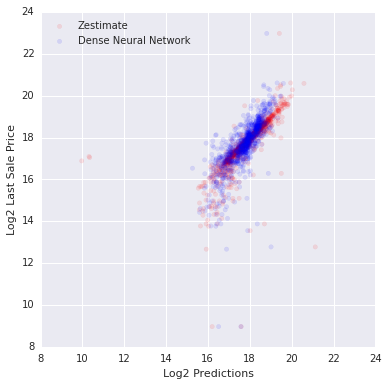

In [22]:
fr_preds = fr.predict(vf[test_ixs]).reshape((test_df.shape[0],))

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    fr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Dense Neural Network", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Dense Network with Attention Mechanism
I hypothesize that different properties are given different weight in different regions. We'll break our feature vector up into two parts: first, binary features for home properties; and second, region embeddings.

The final output will be the sum of a regional bias, and home desirability value multiplied by a regional scale value.

Regional bias and scale will be learned from the region embeddings alone. Home desirability will be learned from home properties, as filtered through an attention matrix learned from the region embeddings.

```
█████████████████████            █████████████████████
█ region_embeddings █            █ binary_properties █
█████████████████████            █████████████████████
      |\__      \____________             *
      |   \__                \---- attention_matrix
      |      \__                          =
      |         \__                     hidden
      |            \                      |                █████████
regional_bias  +  (regional_scale  *  home_desirability) = █ price █
                                                           █████████
                                                           ```

In [50]:
# Binary vectorization of properties only, without regions
_, vp = zillow.VectorizeFacts(df.facts)
vp.shape

(9288, 401)

In [209]:
def AttentiveRegressor(
        n_regions, n_facts,
        region_embedding_size=16,
        hidden_sizes=[128, 64, 32, 16],
        nonlin=layers.advanced_activations.ELU):
    # Embeddings
    embed = models.Sequential()
    embed.add(layers.embeddings.Embedding(n_regions, region_embedding_size, input_length=1))
    embed.add(layers.Reshape((region_embedding_size,)))
    embed.add(layers.Dropout(0.5))

    # Regional Mean
    reg_bias = models.Sequential()
    reg_bias.add(embed)
    reg_bias.add(layers.Dense(1))
    reg_bias.add(layers.Activation("relu"))
    reg_bias.add(layers.Lambda(lambda x: x + 1.0))

    # Regional Scale
    reg_scale = models.Sequential()
    reg_scale.add(embed)
    reg_scale.add(layers.Dense(1))
    reg_scale.add(layers.Activation("relu"))
    reg_scale.add(layers.Lambda(lambda x: x + 0.1))

    # Properties
    props = models.Sequential()
    props.add(layers.Reshape((n_facts,), input_shape=(n_facts,)))

    # Attention
    att = models.Sequential()
    att.add(embed)
    att.add(layers.Dense(n_facts))
    att.add(layers.Activation("sigmoid"))
    att_output = layers.Merge([att, props], mode="mul")

    # Home Desirability
    desire = models.Sequential()
    desire.add(att_output)
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            desire.add(layers.Dropout(0.5))
        desire.add(layers.Dense(out_size, input_dim=in_size))
        if i < len(sizes) - 1:
            desire.add(nonlin())
        else:
            desire.add(layers.Activation("relu"))
            desire.add(layers.Lambda(lambda x: x + 1.0))

    # Output
    scale_x_desirability = layers.Merge([reg_scale, desire], mode="mul")
    raw_output = layers.Merge([reg_bias, scale_x_desirability], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [210]:
ar = AttentiveRegressor(len(df.region.unique()), vp.shape[1], hidden_sizes=[258, 128, 64, 32, 16])

In [211]:
ar.compile(optimizer="adam", loss="mse")

In [212]:
ar_history = ar.fit(
    [train_df.region_code, vp[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=500,
    verbose=0,
    validation_data=(
        [test_df.region_code, vp[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True)

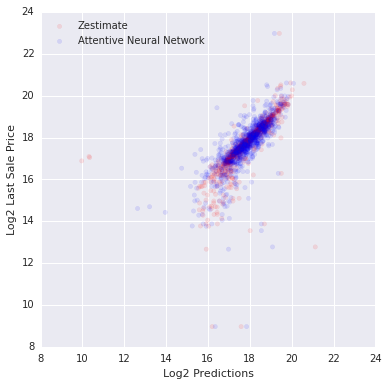

In [213]:
ar_preds = ar.predict([test_df.region_code, vp[test_ixs]]).reshape((test_df.shape[0],))

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    ar_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Attentive Neural Network", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

# Build a network in Keras to Learn from Images

In [222]:
zillow.LoadImageDataIntoDataFrame(df, "data/")
images = np.array(df.image.tolist())

In [218]:
def ConvolutionalRegressor(n_regions, region_embedding_size=16):
    # Embeddings
    embed = models.Sequential()
    embed.add(layers.embeddings.Embedding(n_regions, region_embedding_size, input_length=1))
    embed.add(layers.Reshape((region_embedding_size,)))
    embed.add(layers.Dropout(0.5))

    # Regional Mean
    reg_bias = models.Sequential()
    reg_bias.add(embed)
    reg_bias.add(layers.Dense(1))
    reg_bias.add(layers.Activation("relu"))
    reg_bias.add(layers.Lambda(lambda x: x + 1.0))

    # Regional Scale
    reg_scale = models.Sequential()
    reg_scale.add(embed)
    reg_scale.add(layers.Dense(1))
    reg_scale.add(layers.Activation("relu"))
    reg_scale.add(layers.Lambda(lambda x: x + 0.1))

    # Desirability from Image
    img_model = models.Sequential()

    img_model.add(layers.Conv2D(32, 5, 5, border_mode="same", input_shape=(128, 128, 3)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(48, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(64, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(96, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(128, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))
    
    img_model.add(layers.Conv2D(1, 4, 4, border_mode="valid"))
    img_model.add(layers.Reshape((1,)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.Activation("relu"))
    img_model.add(layers.Lambda(lambda x: x + 1.0))
    
    # Output
    scale_x_desirability = layers.Merge([reg_scale, img_model], mode="mul")
    raw_output = layers.Merge([reg_bias, scale_x_desirability], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [234]:
cr = ConvolutionalRegressor(len(df.region.unique()))

In [235]:
cr.compile(optimizer="adam", loss="mse")

In [236]:
cr_history = cr2.fit(
    [train_df.region_code, images[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=16,
    nb_epoch=10,
    verbose=1,
    validation_data=(
        [test_df.region_code, images[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: {0: 1.0, 1: 0.3, 2: 0.1, 3: 0.03, 4: 0.01, 5: 0.003}.get(ep, 0.001))])

Train on 8360 samples, validate on 928 samples
Epoch 1/10
8360/8360 [==============================] - 1100s - loss: 6.4517 - val_loss: 2.2943
Epoch 2/10
8360/8360 [==============================] - 1098s - loss: 1.5252 - val_loss: 1.8947
Epoch 3/10
8360/8360 [==============================] - 1226s - loss: 1.5785 - val_loss: 1.8877
Epoch 4/10
8360/8360 [==============================] - 1219s - loss: 1.3028 - val_loss: 1.8813
Epoch 5/10
8360/8360 [==============================] - 1139s - loss: 1.4319 - val_loss: 1.8783
Epoch 6/10
8360/8360 [==============================] - 1153s - loss: 1.4181 - val_loss: 1.8773
Epoch 7/10
8360/8360 [==============================] - 1135s - loss: 1.4019 - val_loss: 1.8772
Epoch 8/10
8360/8360 [==============================] - 1133s - loss: 1.4148 - val_loss: 1.8767
Epoch 9/10
8360/8360 [==============================] - 1065s - loss: 1.3417 - val_loss: 1.8764
Epoch 10/10
8360/8360 [==============================] - 1007s - loss: 1.2727 - val_loss:

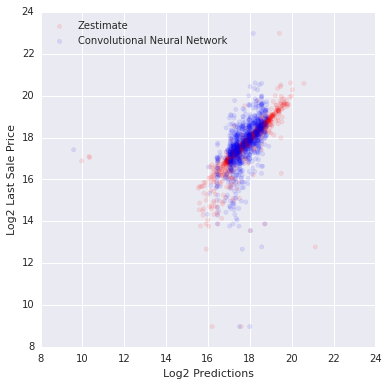

In [243]:
cr_preds = cr.predict([test_df.region_code, images[test_ixs]]).reshape((test_df.shape[0],))

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    cr2_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Convolutional Neural Network", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

# Model Results Comparison

In [245]:
model_names = [
    "zestimate",
    "dense network", "attentive network", "convolutional network",
    "ridge regression", "linear regression", "random forest regression"]
log2_preds_by_model = [
    np.log2(test_df.zestimate),
    fr_preds, ar_preds, cr_preds,
    rr_preds, olsr_preds, rfr_preds]
preds_by_model = [np.exp2(preds) for preds in log2_preds_by_model]
targets = test_df.last_sold
log2_targets = np.log2(targets)
results_df = pd.DataFrame({
    "model": model_names,
    "mean abs log2 err": [(preds - log2_targets).abs().mean() for preds in log2_preds_by_model],
    "mean abs error": [(preds - targets).abs().mean() for preds in preds_by_model],
    "median abs error": [(preds - targets).abs().median() for preds in preds_by_model],
    "median error %": [round(((preds - targets) / targets).abs().median() * 100, 2) for preds in preds_by_model],
    "mean error %": [round(((preds - targets) / targets).abs().mean() * 100, 2) for preds in preds_by_model]})
results_df.sort_values("mean abs error")

,mean abs error,mean abs log2 err,mean error %,median abs error,median error %,model
0,68847.003233,0.324793,14789.20,15257.500000,6.52,zestimate
2,103208.184827,0.503804,19118.05,47744.789062,21.54,attentive network
1,103864.558947,0.505633,20308.15,43225.210938,21.37,dense network
4,106708.001391,0.525734,16597.63,47876.257398,22.69,ridge regression
5,106874.752649,0.526829,16563.06,47863.288338,22.70,linear regression
3,130561.469349,0.699407,20385.98,62546.257812,29.69,convolutional network
6,137859.585430,0.709775,18944.77,64716.542370,31.42,random forest regression
